## Open exploration with Pairplot

In this notebook an open exploration is done to explore how different policy options result in different outcomes relevant for the dike ring stakeholders. 8 policies are created to test how the Dike increase, Room for River and Early Warning System influence the Expected Annual Damage, Total Costs and Expected Number of Deaths. 

In [1]:
# Necessary imports in this notebook
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# Necessary imports in this notebook
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import MultiprocessingEvaluator, Policy
from ema_workbench.util import ema_logging

In [3]:
# Set seed to 0 to make notebook reproducable
np.random.seed(0)

In [4]:
# Enable sampling for debugging purposes
ema_logging.log_to_stderr(ema_logging.INFO)

# Problem formulation 2 is used to catch broad, aggregated trade offs within the model
problem_formulation_id = 2
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

## 1. Create different policies

In this part of the notebook the settings for the different input settings (Levers) are set. All policies will either take the value 0 or 10 for Dike Increase, 0 or 1 for RfR and 0 or 3 for Days to Threat. 

In [5]:
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [6]:
###all no-warning policies to reproduce preliminary model setup

#pol1w = create_policy({'0_RfR 0': 1,
#'1_RfR 0': 1,
#'2_RfR 0': 1,
#'3_RfR 0': 1,
#'4_RfR 0': 1,
#'DaysToThreat': 0,
#'A.1_Dike Increase 0': 10,
#'A.2_Dike Increase 0': 10,
#'A.3_Dike Increase 0': 10,
#'A.4_Dike Increase 0': 10,
#'A.5_Dike Increase 0': 10,},'All, no warning')

#pol3w = create_policy({'0_RfR 0': 1,
#'1_RfR 0': 1,
#'2_RfR 0': 0,
#'3_RfR 0': 1,
#'4_RfR 0': 0,
#'EWS_DaysToThreat': 0,
#'A.1_DikeIncrease 0': 0,
#'A.2_DikeIncrease 0': 0,
#'A.3_DikeIncrease 0': 10,
#'A.4_DikeIncrease 0': 0,
#'A.5_DikeIncrease 0': 10,},'Rural rfr, urban dike, no warning')

#pol4w = create_policy({'0_RfR 0': 0,
#'1_RfR 0': 0,
#'2_RfR 0': 1,
#'3_RfR 0': 0,
#'4_RfR 0': 1,
#'EWS_DaysToThreat': 0,
#'A.1_DikeIncrease 0': 10,
#'A.2_DikeIncrease 0': 10,
#'A.3_DikeIncrease 0': 0,
#'A.4_DikeIncrease 0': 10,
#'A.5_DikeIncrease 0': 0,},'Urban rfr, rural dike, no warning')

In [7]:
# Create the different policies based on different levers settings
pol1 = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 0,
 '3_RfR 0': 0,
 '4_RfR 0': 0,
 'DaysToThreat': 0,
 'A.1_Dike Increase 0': 0,
 'A.2_Dike Increase 0': 0,
 'A.3_Dike Increase 0': 0,
 'A.4_Dike Increase 0': 0,
 'A.5_Dike Increase 0': 0,},'No Action')

pol2 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'DaysToThreat': 3,
 'A.1_Dike Increase 0': 10,
 'A.2_Dike Increase 0': 10,
 'A.3_Dike Increase 0': 10,
 'A.4_Dike Increase 0': 10,
 'A.5_Dike Increase 0': 10,},'All')

pol3 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 0,
 '3_RfR 0': 1,
 '4_RfR 0': 0,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 10,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 10,},'Rural rfr, urban dike')
 
pol4 = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 1,
 '3_RfR 0': 0,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 10,
 'A.2_DikeIncrease 0': 10,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 10,
 'A.5_DikeIncrease 0': 0,},'Urban rfr, rural dike')
 
pol5 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 0,
 '4_RfR 0': 0,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 10,
 'A.5_DikeIncrease 0': 10,},'Upstream rfr, downstream dike')

pol6 = create_policy({'0_RfR 0': 0,
 '1_RfR 0': 0,
 '2_RfR 0': 0,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 10,
 'A.2_DikeIncrease 0': 10,
 'A.3_DikeIncrease 0': 10,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Upstream dike, downstream rfr')

pol7 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Only all rfr executed')

pol8 = create_policy({'0_RfR 0': 1,
 '1_RfR 0': 1,
 '2_RfR 0': 1,
 '3_RfR 0': 1,
 '4_RfR 0': 1,
 'EWS_DaysToThreat': 3,
 'A.1_DikeIncrease 0': 0,
 'A.2_DikeIncrease 0': 0,
 'A.3_DikeIncrease 0': 0,
 'A.4_DikeIncrease 0': 0,
 'A.5_DikeIncrease 0': 0,},'Only all dikes heightened')

# create a list of the different policies
pol_list = [pol1,pol2,pol3,pol4,pol5,pol6,pol7,pol8]

## 2. Use pickle to be able to save time when re-running

In [8]:
from ema_workbench import Samplers

# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True
if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 1000  # 1000 scenarios multiplied with 8 policies 
    with MultiprocessingEvaluator(dike_model, n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list,uncertainty_sampling=Samplers.LHS)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

## 3. Creating pairplot as outcomes

In [9]:
# creating dataframe 

exp, out = results
df = pd.DataFrame(out)
df = df[1:] #The first row is being deleted because it shows a NaN
df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs,Cost plus Damage,policy
1,3.728411e+09,0,0.0,0.000000,4.246190,0.000000e+00,3.728411e+09,Policy_No Action
2,2.222778e+08,0,0.0,0.000000,0.156073,0.000000e+00,2.222778e+08,Policy_No Action
3,2.620957e+09,0,0.0,0.000000,2.046359,0.000000e+00,2.620957e+09,Policy_No Action
4,8.903152e+08,0,0.0,0.000000,0.895560,0.000000e+00,8.903152e+08,Policy_No Action
5,1.256115e+08,0,0.0,0.000000,0.191287,0.000000e+00,1.256115e+08,Policy_No Action
...,...,...,...,...,...,...,...,...
7995,1.700329e+08,0,710400000.0,10020.952960,0.019512,7.104100e+08,8.804429e+08,Policy_Only all dikes heightened
7996,1.845536e+09,0,710400000.0,122787.662537,0.424540,7.105228e+08,2.556059e+09,Policy_Only all dikes heightened
7997,1.666137e+08,0,710400000.0,8157.811091,0.035244,7.104082e+08,8.770218e+08,Policy_Only all dikes heightened
7998,1.919715e+09,0,710400000.0,111607.860007,0.412170,7.105116e+08,2.630227e+09,Policy_Only all dikes heightened


In [10]:
# Pairplot data of Expected Annual Damage, Total Costs and Expected Number of Deaths
pairplot_data = df[["Expected Annual Damage",'Total Costs','Expected Number of Deaths']]
pairplot_data

,Expected Annual Damage,Total Costs,Expected Number of Deaths
1,3.728411e+09,0.000000e+00,4.246190
2,2.222778e+08,0.000000e+00,0.156073
3,2.620957e+09,0.000000e+00,2.046359
4,8.903152e+08,0.000000e+00,0.895560
5,1.256115e+08,0.000000e+00,0.191287
...,...,...,...
7995,1.700329e+08,7.104100e+08,0.019512
7996,1.845536e+09,7.105228e+08,0.424540
7997,1.666137e+08,7.104082e+08,0.035244
7998,1.919715e+09,7.105116e+08,0.412170


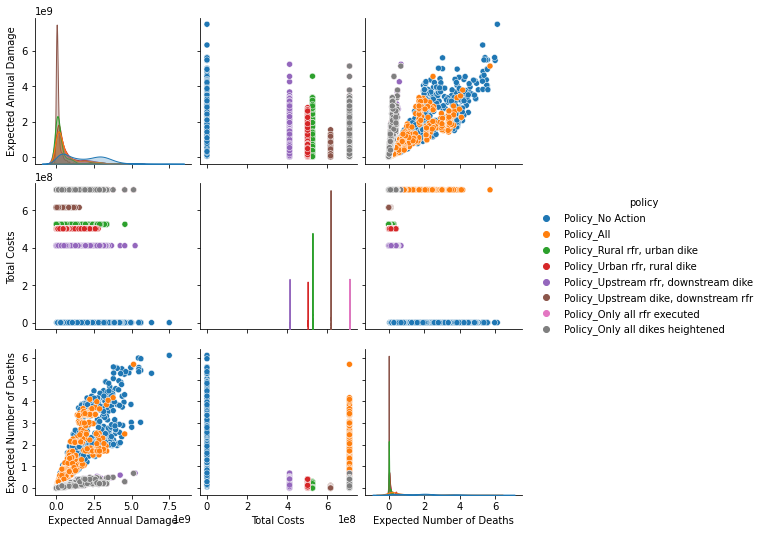

In [11]:
#Pairplot the eight different policies in graphs of the 3 selected pairplot_data outcomes
pairplot = sns.pairplot(df, hue='policy',  vars=pairplot_data)
plt.show()

pairplot.savefig(fname="images/Open exploration/8000_experiments_open_exploration.png", dpi=200,format="png")